## Chapter 13: Multi-layer Perceptrons 

# 13.5  Optimization of Neural Networks

You can toggle the code on and off in this presentation via the button below.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Most learning models employing multi-layer perceptron units are often highly non-convex, a fact that for many years made them difficult to optimize properly. However in addition to many recently created ideas (starting in the early 2000s) that help significantly with the problem of tuning these models, for example the concept of *batch normalization*, we saw in Part I of this text that non-convexity is not by itself not necessarily prohibitive to proper parameter tuning. This is especially true with *first order methods*, i.e., methods derived from gradient descent (as detailed in Sections 3.6 - 3.9), which are the most popular optimization tools used to tune models employing multi-layer perceptrons. Indeed while they are universally applicable many of the practical advanced first order methods described there for extending the standard gradient descent algorithm to better deal with non-convexity were first developed by researchers aiming to improve standard optimization methods to better enable learning with multi-layer perceptrons.

In this Section broadly review the issue of non-convexity when employing multi-layer perceptrons, and highlight those tools introduced in Part I of the text that are especially relevant at optimizing such models.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 13.5.1 Nonconvexity

- In general cost functions employing neural network models have non-convex shapes with long narrow valleys, flat areas, and many saddle points. 

- Even when these cost functions have many *local minima* these tend to lie at a depth close to that of their global minima, and thus tend to provide similar performance if found via local optimization.

- This is starkly different than a kind of hypothetical non-convex cost - not often encountered with neural networks - whose global minima lie considerably lower than its local minima. 



\begin{equation}
\text{model}\left(x,\Theta\right) = \sigma\left(w_0 + w_1x \right).
\end{equation}

Here we can see that the weights of the final linear combination are *fixed*, with the bias set to zero and the weight touching $\sigma\left(\cdot\right)$ set to one. In Example 3 of Section 6.1.4 we plotted the surface of the Least Squares cost employing this network model using a simple toy dataset, which we show again in the figure below for convenience.

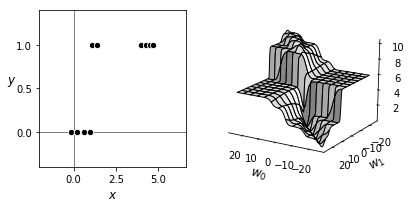

In [2]:
# This code cell will not be shown in the HTML version of this notebook
data = np.loadtxt(datapath + '2d_classification_data_v1_entropy.csv', delimiter = ',')

# create an instance of the visualizer and plot
demo = superlearn.LS_sigmoid.Visualizer(data)
demo.plot_costs(viewmax = 25, view = [21,121])

Examining the general shape of the cost function in the right panel, firstly we can clearly see that it is non-convex. Several portions of the cost surface - on either side of the *long narrow valley* containing the cost's global minimum - *are almost completely flat*, likely containing *saddle points* that can halt most basic optimization schemes. As described in Chapter 4 (and Section 4.5 in particular), without serious adjustment second order methods struggle to minimize functions like this. These aspects of the non-convexity are also very problematic for the *basic* gradient descent algorithm - as detailed in Section 3.5. However gradient descent can be easily enhanced to deal with *precisely* these issues - as discussed in Sections 3.6 - 3.9.  Indeed both aspects of the non-convexity we see here -  both the *long narrow valley* and the *flat areas* potentially containing saddle points - were precisely the motivation for *momentum* (see Section 3.7) and *gradient normalization* (see Section 3.8) respectively.  Combining these two enhancements (see Section 3.9), in addition to mini-batch optimization (see Section 3.10), can further enhance gradient based methods so that they can more easily minimize cost functions such as this one.  Indeed back in Example 3 of Section 6.1.4 where this particular cost was first described, we show that the *normalized gradient descent* alone can properly minimize it.

(left) An artistic depiction of the sort of prototypical cost function seen when employing neural network models. (right) An artistic depiction of the sort of bad (difficult to properly minimize) non-convex cost rarely found when using neural networks.
<img src= '../../mlrefined_images/nonlinear_superlearn_images/bad_convex_comparison.png' width="250%" height="auto"/>


They variety of nonconvexity they often exhibit can fairly easily be dealt with using e.g., momentum-based and gradient normalization schemes detailed in Appendix A of the text. 

#### <span style="color:#a50e3e;">Example.</span>  Comparing first-order optimizers on a multi-layer neural network model

- In this example we use $P = 50,000$ randomly selected data points from the MNIST dataset to perform multi-class classification (C = 10) using a four-hidden-layer neural network with ten units per layer, and a tanh activation.

- Here we compare the efficacy of three first-order optimizers: the standard gradient descent scheme (see Section 3.5), its component-normalized version (see Section A.3.2), and RMSProp (see Section A.4).

- Each optimizer is used in both batch and mini-batch (using batch size of 200) regimes (see Section 7.8) to minimize the multi-class Softmax cost over this data. 

#### Batch version

<img src= '../../mlrefined_images/nonlinear_superlearn_images/batch.png' width="250%" height="auto"/>


#### Mini-batch version

<img src= '../../mlrefined_images/nonlinear_superlearn_images/mini-batch.png' width="250%" height="auto"/>


In [3]:
# This code cell will not be shown in the HTML version of this notebook
# load data
from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original')
x = MNIST.data.astype('float64').T
y = np.reshape(MNIST.target, (-1, 1)).T
num_pts = np.size(y)

# subsample
num_samples = 50000
inds = np.random.permutation(num_pts)[:num_samples]
x_sample = x[:,inds]
y_sample = y[:,inds]

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# import the v1 library
mylib0 = nonlib.mlp_complib.superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10,10,10,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'tanh')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
# mylib0.fit(max_its = 10,alpha_choice = alpha,beta = 0.9)
mylib0.fit(max_its = 10,alpha_choice = alpha,normalize = True)
# mylib0.fit(max_its = 10,alpha_choice = alpha,optimizer = 'RMSprop')

# show histories
labels = ['standard','normalized']
mylib0.show_histories(labels = labels)

<IPython.core.display.Javascript object>


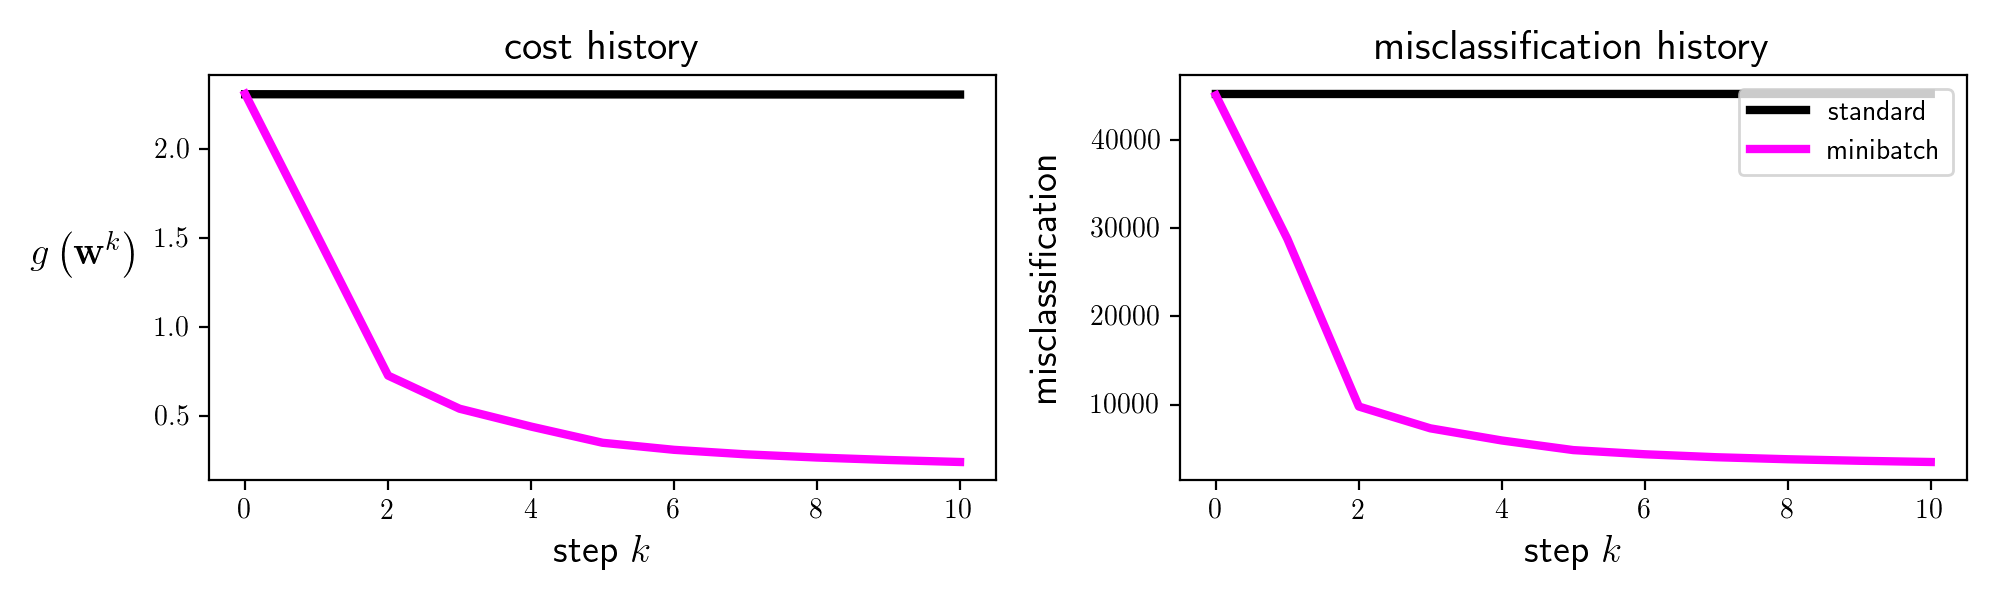

In [68]:
## This code cell will not be shown in the HTML version of this notebook
# import the v1 library
mylib0 = nonlib.mlp_complib.superlearn_setup.Setup(x_sample,y_sample)

# choose features
layer_sizes = [784,10,10,10,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'relu')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
mylib0.fit(max_its = 10,alpha_choice = alpha,batch_size = 200)
# mylib0.fit(max_its = 10,alpha_choice = alpha,normalize = True)
# mylib0.fit(max_its = 10,alpha_choice = alpha,optimizer = 'RMSprop')

# show histories
labels = ['standard','minibatch']
mylib0.show_histories(labels = labels)